<a href="https://colab.research.google.com/github/jsavage/Piwigo-2FA-investigation/blob/main/2FA_QRCode_Test%26Diag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
pip install pillow pyzbar qrcode pyzbar

### Outcome
Running this notebook will:
- Read the attached photograph’s QR code.
- Print whether it’s base64-wrapped or a direct URI.
- Display both outer and inner QR images.
- Generate a new, valid otpauth QR for import into Google Authenticator.

In [13]:
!apt-get install -y zbar-tools

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zbar-tools is already the newest version (0.23.92-4build2).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [1]:
# Replace 'myscript.py' with the actual name of your uploaded .py file
!python twoFAQRTest.py

python3: can't open file '/content/twoFAQRTest.py': [Errno 2] No such file or directory


In [ ]:
from google.colab import files

print('Please upload your image file:')
uploaded = files.upload()

# Get the first uploaded filename
image_path = next(iter(uploaded.keys()))
print(f"Selected image: {image_path}")

Please upload your image file:


✅ Environment ready.
Using uploaded image: BTOSC_TEST 2026-01-01 (4).jpeg


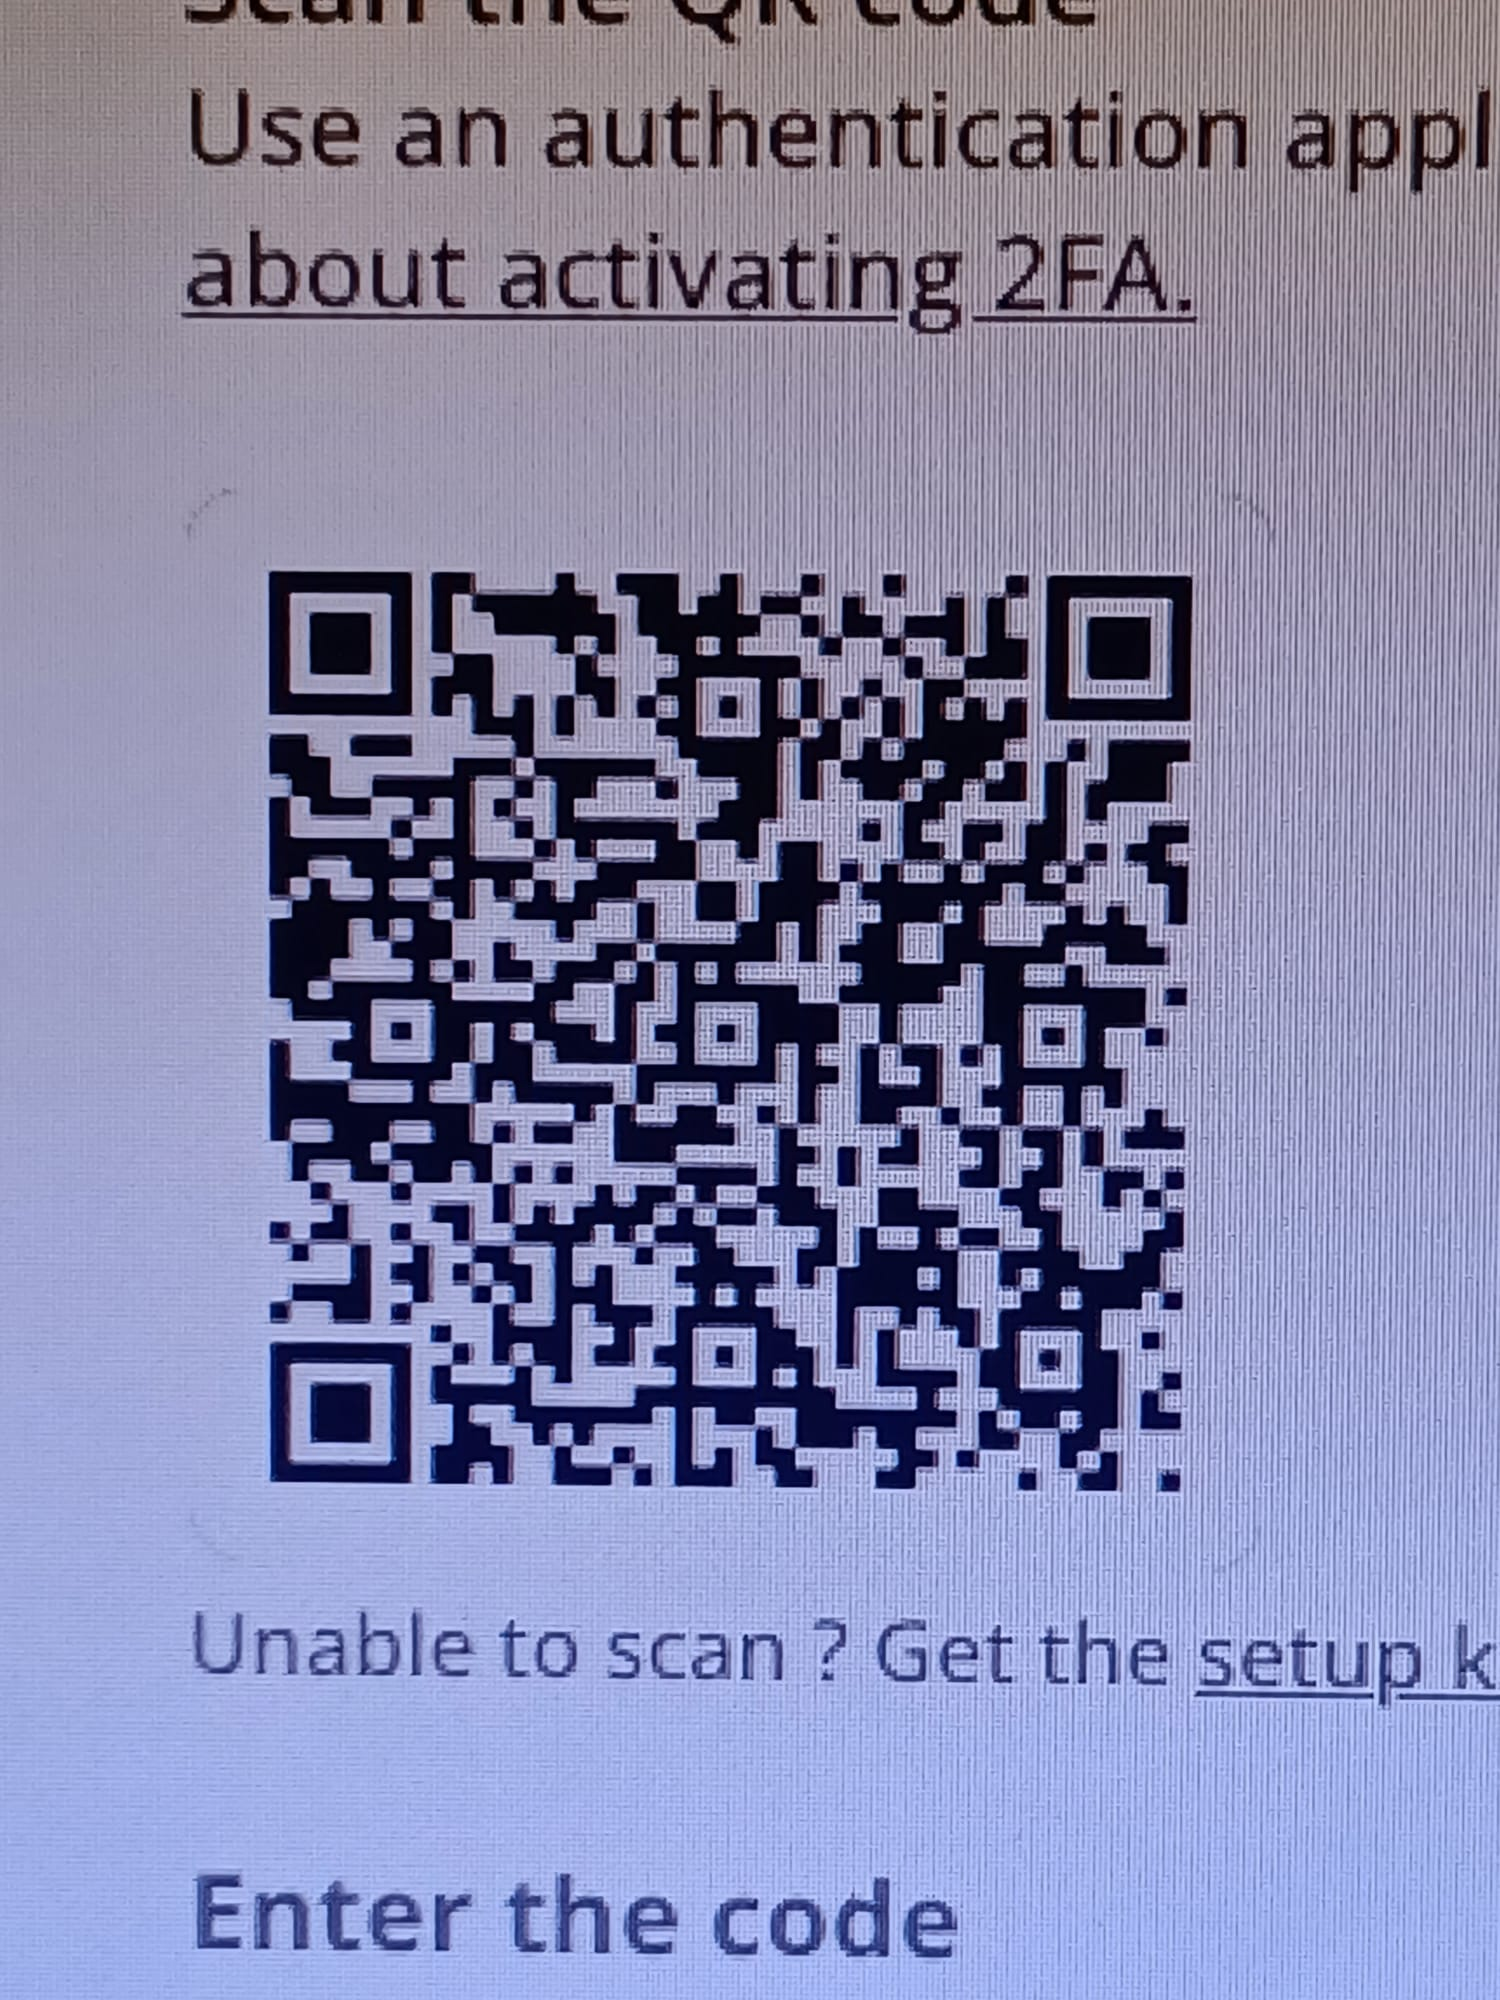

In [9]:
from pyzbar.pyzbar import decode
from PIL import Image
from IPython.display import display
import base64, io, re, qrcode

print("✅ Environment ready.")

# --- 1️⃣ Load the image using the image_path defined by the previous upload cell ---
# The 'image_path' variable should have been set by the preceding cell (e.g., cell 34fe258b).
if 'image_path' not in locals() or image_path is None:
    raise RuntimeError("❌ No image path found. Please run the interactive image upload cell (e.g., cell 34fe258b) first.")

print(f"Using uploaded image: {image_path}")

img = Image.open(image_path)
display(img)


In [10]:
# --- 2️⃣ Decode the outer QR content ---
decoded_outer = decode(img)
if not decoded_outer:
    raise RuntimeError("❌ No QR code detected in image.")

outer_data = decoded_outer[0].data.decode("utf-8")
print("First 200 characters of QR data:")
print(outer_data[:200] + ("..." if len(outer_data) > 200 else ""))

if outer_data.startswith("otpauth://"):
    print("✅ QR data begins with otpauth:// — fully standards‑compliant.")
else:
    print("❌ Not a standards‑compliant QR. Apps expecting otpauth:// (e.g. Google Authenticator) will reject it.")



RuntimeError: ❌ No QR code detected in image.

In [11]:
# --- 3️⃣ If this QR wraps a base64 PNG, decode and inspect it ---
match = re.match(r"data:image/png;base64,(.*)", outer_data)
inner_text = None

if match:
    print("Outer QR embeds a Base64 PNG. Decoding that inner image …")
    inner_png_bytes = base64.b64decode(match.group(1))
    inner_img = Image.open(io.BytesIO(inner_png_bytes))
    display(inner_img)

    inner_decoded = decode(inner_img)
    if not inner_decoded:
        raise RuntimeError("❌ Inner PNG does not itself contain a QR code.")
    inner_text = inner_decoded[0].data.decode("utf-8")
    print("Decoded text from inner QR:")
    print(inner_text)
else:
    print("No nested PNG detected; outer QR itself is the final data.")
    inner_text = outer_data





NameError: name 'outer_data' is not defined

In [ ]:
# --- 4️⃣ Evaluate the decoded or corrected content ---
if inner_text.startswith("otpauth://"):
    print("✅ Valid TOTP otpauth URI detected.")
else:
    print("❌ Still not an otpauth:// URI.")
    print("This confirms the plugin wraps binary data rather than the provisioning URI itself.")


In [ ]:
# --- 5️⃣ Generate a corrected demo QR for comparison ---
# (For demonstration only — replace with your true otpauth URI if recovered)
correct_uri = inner_text if inner_text.startswith("otpauth://") else \
    "otpauth://totp/Piwigo:example_user?secret=EXAMPLESECRET123&issuer=Piwigo"

qr = qrcode.QRCode(border=2, box_size=8)
qr.add_data(correct_uri)
qr.make(fit=True)
fixed_img = qr.make_image(fill_color="black", back_color="white")

print("✅ Standards‑compliant QR generated (sample):")
display(fixed_img)

print("This walks through a full diagnostic: failure under strict apps ➜ analysis ➜ corrected QR demonstration.")